In [55]:
import scipy.io as scio
import hdf5storage
import numpy as np
import matplotlib.pyplot as plt
import math

In [61]:
data = hdf5storage.loadmat('./data/indy_20160407_02.mat')

In [62]:
neuron_spikes = data['spikes']
neuron_spikes = neuron_spikes.reshape(-1)

cursor_pos = data['cursor_pos']
target_pos = data['target_pos']
reg_times = data['t'].reshape(-1)

In [63]:
# Search for the indices where target change 
tgt_chg_indices = [0]

for i in range(1, len(target_pos)):
    if np.sum(target_pos[i] == target_pos[i-1]) != 2:
        tgt_chg_indices.append(i)

# Capture cursor shifts according to the above indices
cursor_shifts = np.zeros([len(tgt_chg_indices), 2])

cursor_vs = np.zeros([len(tgt_chg_indices), 2])

tgt_chg_slices = []

for i in range(len(tgt_chg_indices)):
    start_idx = tgt_chg_indices[i]
    end_idx = tgt_chg_indices[i+1] if i < len(tgt_chg_indices) - 1 else -1
    cursor_shifts[i] = cursor_pos[end_idx] - cursor_pos[start_idx]
    cursor_vs[i] = cursor_shifts[i] / (reg_times[end_idx]-reg_times[start_idx])
    tgt_chg_slices.append([start_idx, end_idx])

cursor_shifts_norms = np.linalg.norm(cursor_shifts, axis=1)

# keep shifts with norm > 1
cursor_shifts = cursor_shifts[cursor_shifts_norms>1]
cursor_vs = cursor_vs[cursor_shifts_norms>1]
tgt_chg_slices = np.array(tgt_chg_slices)[cursor_shifts_norms>1]
normed_cursor_shifts = cursor_shifts / np.linalg.norm(cursor_shifts, axis=1, keepdims=True)

# Eight reference directions
refer_dirc = np.array([[0., 1.],
                       [1./math.sqrt(2), 1./math.sqrt(2)],
                       [1., 0.],
                       [1./math.sqrt(2), -1./math.sqrt(2)],
                       [0., -1.],
                       [-1./math.sqrt(2), -1./math.sqrt(2)],
                       [-1., 0.],
                       [-1./math.sqrt(2), 1./math.sqrt(2)]])

# Compute cosine similarity
cos_sim = normed_cursor_shifts @ refer_dirc.T

# Compute the angle between shifts and reference directions
angles = np.arccos(cos_sim) / np.pi * 180

# Consider waves with only angle < 10
timestamps_slices_collection = [[] for i in range(8)]

for i in range(8):
    mask = (np.argmin(angles, axis=1)==i) * (np.min(angles, axis=1)<10)
    timestamps_slices_collection[i] = (tgt_chg_slices[mask], cursor_vs[mask])


/tmp/ipykernel_350642/2114295112.py:19: RuntimeWarning: invalid value encountered in true_divide
  cursor_vs[i] = cursor_shifts[i] / (reg_times[end_idx]-reg_times[start_idx])


In [64]:
import bisect
import copy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

r2_scores = []

for i, neuron_spike in enumerate(neuron_spikes):
    
    firing_rates = []
    velocities = []

    neuron_spike = neuron_spike.reshape(-1)

    if len(neuron_spike) == 0:
        continue

    for i in range(8):
        
        index_slices, vs = timestamps_slices_collection[i]
        
        for i, start_end in enumerate(index_slices):
            start, end = start_end

            s_start_idx = min(bisect.bisect_left(neuron_spike, reg_times[start]), len(neuron_spike)-1)
            s_end_idx   = min(bisect.bisect_right(neuron_spike, reg_times[end]), len(neuron_spike)-1)

            s_start, s_end = neuron_spike[s_start_idx], neuron_spike[s_end_idx]

            firing_times = s_end_idx - s_start_idx + 1 
            firing_interval = s_end - s_start

            if firing_interval == 0:
                continue
            
            firing_rates.append(firing_times/firing_interval)
            velocities.append(vs[i])

    model = LinearRegression()
    velocities = np.stack(velocities)
    firing_rates = np.array(firing_rates)
    
    model.fit(velocities, firing_rates)

    y_pred = model.predict(velocities)

    r2 = r2_score(firing_rates, y_pred)
    r2_scores.append(r2)
    


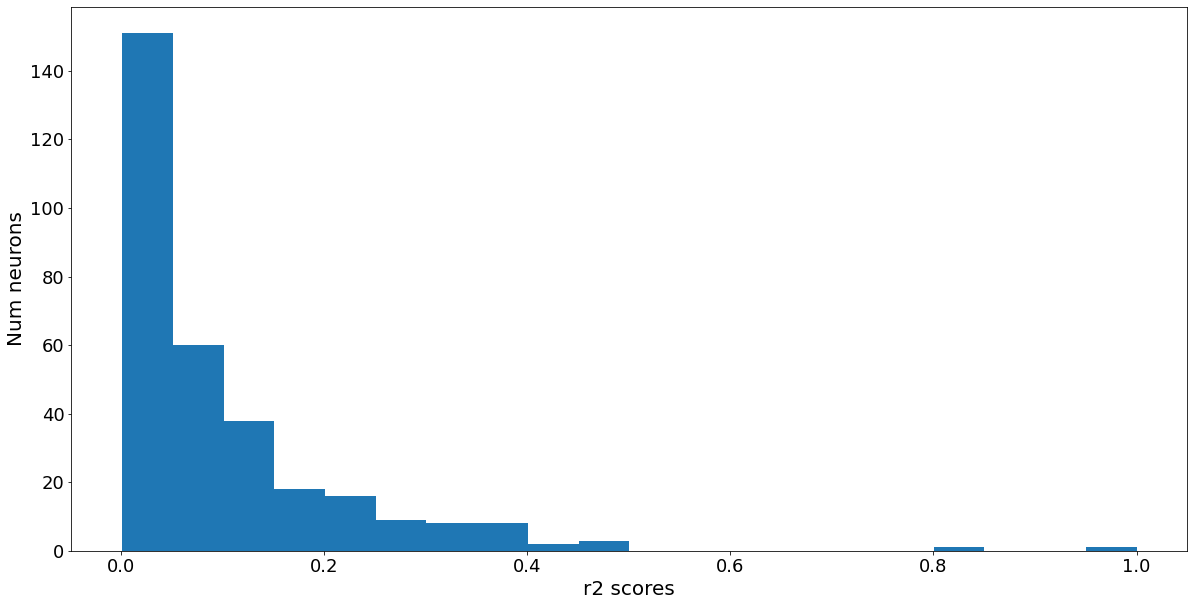

In [65]:
plt.figure(figsize=(20, 10))
plt.ylabel('Num neurons', size=20)
plt.xlabel('r2 scores', size=20)
plt.tick_params(labelsize=18)

plt.hist(r2_scores, bins=20)
plt.savefig('./imgs/r2_scores.jpg')